In [1]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import bioframe
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [4]:
# import HiC map in .cool or .mcool 
# note: if you are importing .mcool file, you should specify the resolution
clr = cooler.Cooler('[pass to your .cool or .mcool file]/GSE130275_mESC_WT_combined_2.6B.mcool::/8')
resolution = clr.binsize
print(resolution)

51200


In [5]:
# computing the expected values for each diagonal in cis
view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
expected = cooltools.expected_cis(clr, view_df=view_df, nproc=2, chunksize=1_000_000)

In [7]:
# import .gft file to extract Gene/transcript information
df_gene0 = read_gtf("[pass to your .gtf file]/mm10.ensGene.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
df_gene0 = df_gene0[df_gene0['chrom'].isin(clr.chromnames)]
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
1449882,chrY,90753057,90763485,+,ENSMUSG00000095134,10428
1449890,chrY,90754513,90754821,-,ENSMUSG00000095366,308
1449895,chrY,90784738,90816439,+,ENSMUSG00000096768,31701
1449950,chrY,90837413,90844040,+,ENSMUSG00000099871,6627


In [8]:
# select a subset of genes based on size, chromosome, ...
# Note: the minimum size of the gene is better to be 10 times higher than HiC resolution
df_gene = df_gene0[(df_gene0['length']<=20*resolution)&(df_gene0['length']>=10*resolution)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,8361475,9299238,-,ENSMUSG00000025909,937763
1,chr1,11414105,11975901,+,ENSMUSG00000057715,561796
2,chr1,20057779,20618064,-,ENSMUSG00000043760,560285
3,chr1,21398408,21961942,-,ENSMUSG00000028033,563534
4,chr1,22286251,22805724,-,ENSMUSG00000041670,519473
...,...,...,...,...,...,...
146,chrX,42532391,43274786,-,ENSMUSG00000016150,742395
147,chrX,113297510,113836386,+,ENSMUSG00000025592,538876
148,chrX,120290327,120910619,+,ENSMUSG00000034755,620292
149,chrX,129749742,130465831,+,ENSMUSG00000034480,716089


In [9]:
# compute intra-gene contact (IC) score, using cooltools.pileup module
flank = (max(df_gene.length))//2
stack = cooltools.pileup(clr, df_gene, view_df=view_df, expected_df=expected, flank=flank)
l = len(df_gene)
fm = flank//resolution
for i in range (l):
    lm = ((df_gene.length[i])//2)//resolution
    b = stack[fm-lm:fm+lm+1,fm-lm:fm+lm+1,i]
    a = b[np.triu_indices(2*lm+1, k = 2)]
    df_gene.loc[i,'ic_score'] = np.nanmean(a)
display(df_gene)

,chrom,start,end,strand,gene_id,length,ic_score
0,chr1,8361475,9299238,-,ENSMUSG00000025909,937763,1.282613
1,chr1,11414105,11975901,+,ENSMUSG00000057715,561796,0.703375
2,chr1,20057779,20618064,-,ENSMUSG00000043760,560285,0.909535
3,chr1,21398408,21961942,-,ENSMUSG00000028033,563534,1.133858
4,chr1,22286251,22805724,-,ENSMUSG00000041670,519473,0.763626
...,...,...,...,...,...,...,...
146,chrX,42532391,43274786,-,ENSMUSG00000016150,742395,1.174774
147,chrX,113297510,113836386,+,ENSMUSG00000025592,538876,1.000203
148,chrX,120290327,120910619,+,ENSMUSG00000034755,620292,0.772406
149,chrX,129749742,130465831,+,ENSMUSG00000034480,716089,0.828298


In [10]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
pol2 = pyBigWig.open("[pass to your .bigwig file]/GSM4173524_DMSO-N20-input_rep1.bw")
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'ir_score'] = np.mean(pol2.values(ch,start,end))
display(df_gene)

,chrom,start,end,strand,gene_id,length,ic_score,ir_score
0,chr1,8361475,9299238,-,ENSMUSG00000025909,937763,1.282613,0.630071
1,chr1,11414105,11975901,+,ENSMUSG00000057715,561796,0.703375,0.521960
2,chr1,20057779,20618064,-,ENSMUSG00000043760,560285,0.909535,0.328773
3,chr1,21398408,21961942,-,ENSMUSG00000028033,563534,1.133858,0.260465
4,chr1,22286251,22805724,-,ENSMUSG00000041670,519473,0.763626,0.399117
...,...,...,...,...,...,...,...,...
146,chrX,42532391,43274786,-,ENSMUSG00000016150,742395,1.174774,0.215916
147,chrX,113297510,113836386,+,ENSMUSG00000025592,538876,1.000203,0.173354
148,chrX,120290327,120910619,+,ENSMUSG00000034755,620292,0.772406,0.173279
149,chrX,129749742,130465831,+,ENSMUSG00000034480,716089,0.828298,0.475498


0.1520848800458177


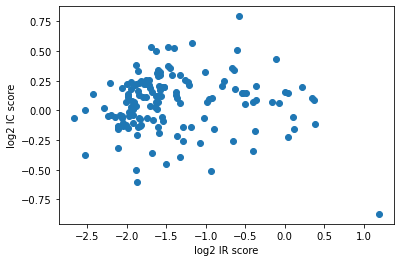

In [11]:
# plotting IC score against IR score and computing the Spearman's correlation
df_gene.loc[:,'log2_ic_score'] = np.log2(df_gene['ic_score'].replace(0,np.nan))
df_gene.loc[:,'log2_ir_score'] = np.log2(df_gene['ir_score'].replace(0,np.nan))
plt.scatter(df_gene['log2_ir_score'],df_gene['log2_ic_score'])
plt.xlabel('log2 IR score')
plt.ylabel('log2 IC score')
print(df_gene['log2_ir_score'].corr(df_gene['log2_ic_score'],method='spearman'))